In [21]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}<style>"))

In [177]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
import keras.backend as K
from keras.utils import multi_gpu_model, np_utils
from keras.models import load_model
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import random
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax
import os
import warnings
warnings.simplefilter("ignore", np.RankWarning)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7"
GPU_MEMORY_FRACTION = 0.1
DATA_SHAPE = 224

In [7]:
def config_keras_backend(fraction):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = fraction 
    sess = tf.Session(config=config)
    K.set_session(sess)

# config_keras_backend(GPU_MEMORY_FRACTION)
val_labels = np.load('/home/mc16/pre_data/val_label_%s.npy'%DATA_SHAPE)
val_images = np.load('/home/mc16/pre_data/val_image_%s.npy'%DATA_SHAPE)
val_masks = np.load('/home/mc16/result/val_masks_06-12-00:43:14.npy')

In [8]:
# model = load_model('seg0608.h5')

# load trained model
from keras.models import model_from_json
from keras.models import load_model
# 从.json和.h5载入模型的结构和权重
model = model_from_json(open('/home/mc16/model3/segmodel_structure_1.json').read())
model.load_weights('/home/mc16/model3/segmodel_weights_1.h5')

InternalError: Failed to create session.

In [11]:
def crf_image(img, model):
    img = cv2.resize(img, (DATA_SHAPE, DATA_SHAPE))
    score = model.predict(np.expand_dims(img,axis=0))

    softmax = score[0].transpose((2, 0, 1)) # [channel,shap,shape]
    # The input should be the negative of the logarithm of probability values
    # Look up the definition of the softmax_to_unary for more information
    unary = unary_from_softmax(softmax)
    # The inputs should be C-continious -- we are using Cython wrapper
    unary = np.ascontiguousarray(unary)#(2,n)
    crf = dcrf.DenseCRF(img.shape[0] * img.shape[1], 2)
    crf.setUnaryEnergy(unary)

    # This potential penalizes small pieces of segmentation that are
    # spatially isolated -- enforces more spatially consistent segmentations
    feats = create_pairwise_gaussian(sdims=(2, 3), shape=img.shape[:2])
    crf.addPairwiseEnergy(feats, compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This creates the color-dependent features --
    # because the segmentation that we get from CNN are too coarse
    # and we can use local color features to refine them
    feats = create_pairwise_bilateral(sdims=(20, 100), schan=(20, 20, 20), img=img, chdim=2)
    crf.addPairwiseEnergy(feats, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # mean field iteration
    Q = crf.inference(1)
    
    res = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))
    return res    

In [146]:
def cut_top(mask, frac=0.3):
    cut_mask = np.array(mask)
    sum_mask = np.sum(mask, axis=1)
    cut_top = 0
    for i in range(len(sum_mask)):
        if sum_mask[i] > 5:
            cut_top = i
            break
    cut_down = cut_top + int((224 - cut_top) * frac)
    cut_mask[:cut_down,:] = 0
    return cut_mask

def cut_shit(mask, num, frac=0.7):
    cut_mask = np.array(mask)
    for j in range(224):
        for i in range(223-num):
            if np.sum(cut_mask[j, i:i+num]) > num*frac:
                cut_mask[j, i:i+num] = 0
    return cut_mask

test_index = random.randint(0, len(val_labels))
# test_index = 0
test_label = val_labels[test_index,:,:,1]
test_img = val_images[test_index]
test_points = val_masks[test_index]
cut_mask = cut_shit(test_points, 25)
# test_mask = crf_image(test_img, model)
fig, axs = plt.subplots(1, 4, figsize=(30,30)) 
axs[0].imshow(test_img)
axs[1].imshow(test_label,cmap='gray')
axs[2].imshow(test_points,cmap='gray')
axs[3].imshow(cut_mask,cmap='gray')
plt.show()

# Cluster

1044


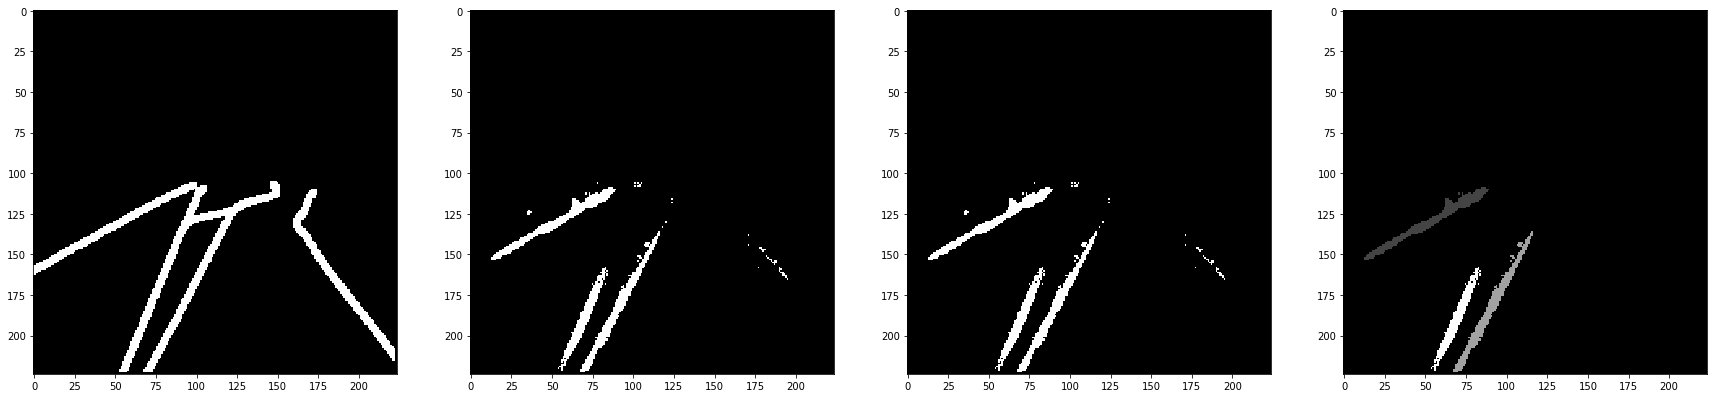

In [184]:
from sklearn.cluster import DBSCAN

def matrix_to_point(matrix):
    points = []
    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            if(matrix[x][y] == 1):
                points.append([x, y])
    return np.array(points, dtype=np.uint8)

def get_cluster_points(points, EPS = 1.5, MIN_SAMPLES = 3, minN=20):
    if len(points) == 0: 
        cluster_points = []
    else:
        arpoints = np.array(points, dtype=np.uint8)
        cluster_label = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit_predict(arpoints)
        max_label = np.max(cluster_label)
        cluster_points = []
        for label in range(-1, max_label+1):
            label_index = np.where(cluster_label == label)
            if(len(label_index[0]) > minN):
                cluster_points.append(arpoints[label_index])
    return np.array(cluster_points)

def cluster_to_img(cluster_points, shape):
    pic = np.zeros((shape, shape), np.uint8)
    num_label = cluster_points.shape[0]
    for i in range(num_label):
        for point in cluster_points[i]:
            pic[point[0], point[1]] = 50 + i * int((255 - 50) / num_label) 
    return pic

test_index = random.randint(0, len(val_labels))
# test_index = 1248
print(test_index)
test_label = val_labels[test_index,:,:,1]
test_points = val_masks[test_index]
cut_mask = cut_shit(test_points, 30, frac=0.6)
points_data = matrix_to_point(cut_mask)
clusters = get_cluster_points(points_data, EPS = 3., MIN_SAMPLES = 3, minN=30)
cluster_img = cluster_to_img(clusters, DATA_SHAPE)

fig, axs = plt.subplots(1, 4, figsize=(30,30)) 
axs[0].imshow(test_label,cmap='gray')
axs[1].imshow(test_points,cmap='gray')
axs[2].imshow(cut_mask,cmap='gray')
axs[3].imshow(cluster_img,cmap='gray')
plt.show()

# Save json

In [ ]:
def cut_cluster_lines(mask_list):
    result = []
    for mask in tqdm(mask_list):
        cut_mask = cut_shit(mask, 30, frac=0.6)
        points_data = matrix_to_point(cut_mask)
        clusters = get_cluster_points(points_data, EPS = 3., MIN_SAMPLES = 3, minN=30)
        result.append(clusters)
    return result

val_clusters = cut_cluster_lines(val_masks)



  0%|          | 0/2015 [00:00<?, ?it/s]

  0%|          | 1/2015 [00:00<19:04,  1.76it/s]

  0%|          | 2/2015 [00:01<18:30,  1.81it/s]

  0%|          | 3/2015 [00:01<17:30,  1.92it/s]

  0%|          | 4/2015 [00:02<17:39,  1.90it/s]

  0%|          | 5/2015 [00:02<17:38,  1.90it/s]

  0%|          | 6/2015 [00:03<17:45,  1.89it/s]

  0%|          | 7/2015 [00:03<18:17,  1.83it/s]

  0%|          | 8/2015 [00:04<18:06,  1.85it/s]

  0%|          | 9/2015 [00:04<18:04,  1.85it/s]

  0%|          | 10/2015 [00:05<18:07,  1.84it/s]

  1%|          | 11/2015 [00:05<18:04,  1.85it/s]

  1%|          | 12/2015 [00:06<18:07,  1.84it/s]

  1%|          | 13/2015 [00:07<18:01,  1.85it/s]

  1%|          | 14/2015 [00:07<17:50,  1.87it/s]

  1%|          | 15/2015 [00:08<18:12,  1.83it/s]

  1%|          | 16/2015 [00:08<18:10,  1.83it/s]

  1%|          | 17/2015 [00:09<18:02,  1.84it/s]

  1%|          | 18/2015 [00:09<17:59,  1.85it/s]

  1%|          | 19/2015 [00:10<18:00,  1.85it/

In [ ]:
import json
def np2json(arlines):
    json_lines = []
    for arline in arlines:
        json_line = []
        for point in arline:
            json_line.append({"x":int(point[1]), "y":int(point[0])})
        json_lines.append(json_line)
    return {"Lanes": json_lines}

def save_jsons(lines_list, list_path, json_path):
    test_md5_paths = open(list_path, 'r').readlines()
    for i, lines in tqdm(enumerate(lines_list)):
        md5 = test_md5_paths[i].split('.')[0]
        lines_json = np2json(lines)
        lines_str = json.dumps(lines_json)
        file = open(json_path + '%s.json'%md5,'w')
        file.write(lines_str)
        file.close()
        
# test_list_path = '/home/mc16/test0_list.txt'
# test_json_path = '/home/mc16/result_json/results/'
# save_jsons(test_lines, test_list_path, test_json_path)

val_list_path = '/data/mc_data/MLDC/data/val/list.txt'
val_json_path = '/home/mc16/result_json/val_results/'
save_jsons(val_clusters, val_list_path, val_json_path)